In [14]:
import os


1. Изучить документацию RESTful API Binance (https://binance-docs.github.io/apidocs/spot/en/) и написать скрипт на Python с использованием библиотеки Requests, чтобы получить данные о котировках криптовалют. Сохранить полученные данные в формате CSV.

In [15]:
# !pip install ccxt
# !pip install pandas


In [16]:
import ccxt
import pandas as pd


In [17]:
start_date = '2021-01-01'
timeframe = '15m'
symbols = ['BTC/USDT','ATOM/USDT']
exchange = 'binance'
path = 'data/'


In [18]:
''' Functions for data fetch '''

def grab_data(source, symbol, timeframe, start_timestamp, path):
    # Get OHLCV data from Binance API
    ohlcv_data = source.fetch_ohlcv(symbol, timeframe, int(start_timestamp), 1000)

    # Convert OHLCV data to Pandas DataFrame
    ohlcv_df = pd.DataFrame(ohlcv_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

    # Convert timestamp from Unix to datetime format
    ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'], unit = 'ms')

    # Set timestamp as index of the DataFrame
    ohlcv_df.set_index('timestamp', inplace=True)

    # Save DataFrame to CSV file
    if not os.path.exists(path):
        os.makedirs(path)
    ohlcv_df.to_csv(f'{path}/{symbol.lower().replace("/", "_")}_historical_data.csv', index=True)
    
    # return ohlcv_df

def grab_and_save_data(exchange, symbols, timeframe, start_date, path):

    # Initialize Binance exchange using ccxt
    source = getattr (ccxt, exchange) ({'enableRateLimit': True})

    # Convert start and end dates to Unix timestamp
    start_timestamp = pd.Timestamp(start_date).timestamp() * 1000

    if isinstance(symbols, list):
        for symbol in symbols:
            grab_data(source, symbol, timeframe, start_timestamp, path)
    else:
        grab_data(source, symbol, timeframe, start_timestamp, path)

grab_and_save_data(exchange, symbols, timeframe, start_date, path)


2. Загрузить полученный CSV-файл с данными в Python с использованием библиотеки Pandas и выполнить предварительную обработку данных (например, удаление пропусков, преобразование даты и времени, масштабирование).

In [19]:
''' '''


def norm(orig_df):
    return (orig_df-orig_df.min())/(orig_df.max()-orig_df.min())

def unnorm(norm_df, orig_df, column = 'close'):
    return norm_df * (orig_df[column].max() - orig_df[column].min()) + orig_df[column].min()
    

def data_preparing(path, symbol):

    # Read CSV file
    ohlcv_df = pd.read_csv(path+symbol.lower().replace("/", "_")+"_historical_data.csv")

    # Convert timetamp to Pandas datetime object
    ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'], format='%Y-%m-%d')

    # ohlcv_df = ohlcv_df.values
    # ohlcv_df = ohlcv_df.astype('float32')
    # Set datetie as index
    ohlcv_df.set_index('timestamp', inplace=True)

    # Scaling data with Pandas and Numpy
    # Min-Max Normalization
    ohlcv_df_norm = norm(ohlcv_df)  # (ohlcv_df-ohlcv_df.min())/(ohlcv_df.max()-ohlcv_df.min()) 
    ohlcv_df_norm

    return ohlcv_df_norm, ohlcv_df

ohlcv_df_norm, ohlcv_df = data_preparing(path, 'ATOM/USDT')

ohlcv_df_norm


,open,high,low,close,volume
timestamp,,,,,
2021-01-01 00:00:00,0.647253,0.626733,0.601648,0.553660,0.110832
2021-01-01 00:15:00,0.553297,0.539101,0.573077,0.515135,0.067115
2021-01-01 00:30:00,0.512637,0.541875,0.573077,0.553660,0.076554
2021-01-01 00:45:00,0.553846,0.613977,0.608242,0.609796,0.069586
2021-01-01 01:00:00,0.609890,0.643927,0.663736,0.630160,0.137154
...,...,...,...,...,...
2021-01-11 08:45:00,0.253846,0.232390,0.275275,0.225647,0.050138
2021-01-11 09:00:00,0.227473,0.215197,0.230769,0.195927,0.046933
2021-01-11 09:15:00,0.195604,0.203550,0.247802,0.223445,0.008003


3. С использованием библиотеки NumPy, разделить данные на обучающую и тестовую выборки.

In [20]:
# import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # Dividing the data into training and test samples
# train_data = ohlcv_df_norm[:int(0.8*len(ohlcv_df_norm))]
# test_data = ohlcv_df_norm[int(0.8*len(ohlcv_df_norm)):]
# scaler = MinMaxScaler()
# ohlcv_df_norm = scaler.fit_transform(ohlcv_df)


In [21]:

# ohlcv_df_norm_ph = tf.Variable(tf.float32, shape=ohlcv_df_norm.shape)

# Split the data into X and y
# assign the data to X and y variables
X = ohlcv_df_norm.drop(columns=["close"])
y = ohlcv_df_norm["close"].shift(1)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)



train_X = np.expand_dims(X_train.values, axis=2)
test_X = np.expand_dims(X_test.values, axis=2)
train_y = np.expand_dims(X_train.values, axis=2)
test_y = np.expand_dims(X_test.values, axis=2)

train_X.shape


(800, 4, 1)

4. Создать и обучить LSTM-модель с использованием библиотеки Keras или TensorFlow на основе подготовленных данных. Подобрать архитектуру и гиперпараметры модели, чтобы достичь наилучшего качества прогнозирования.

In [22]:
# !pip install tensorflow
# !pip install keras


In [23]:
# Создание LSTM-модели
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Компилируем модель
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучаем модель на обучающих данных
history = model.fit(train_X, train_y, batch_size=64, epochs=100, validation_data=(test_X, test_y))

2023-04-08 19:22:12.541787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-08 19:22:12.543694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-08 19:22:12.544979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-04-08 19:22:12.772800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-08 19:22:12.774702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-08 19:22:12.776089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/13 [======================>.......] - ETA: 0s - loss: 0.1088 

2023-04-08 19:22:16.551147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-08 19:22:16.553551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-08 19:22:16.555022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 4s 61ms/step - loss: 0.0988 - val_loss: 0.1075
Epoch 2/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0409 - val_loss: 0.0720
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0370 - val_loss: 0.0816
Epoch 4/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0349 - val_loss: 0.0707
Epoch 5/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0333 - val_loss: 0.0712
Epoch 6/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0324 - val_loss: 0.0699
Epoch 7/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0321 - val_loss: 0.0700
Epoch 8/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0321 - val_loss: 0.0700
Epoch 9/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0321 - val_loss: 0.0700
Epoch 10/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0320 - val_loss: 0.0700
Epoch 11/100
13/1

5. Оценить качество модели на тестовой выборке, используя подходящие метрики, такие как среднеквадратичная ошибка (MSE) или средняя абсолютная ошибка (MAE).


In [24]:
# Получаем предсказания модели
predictions = model.predict(test_X)
predictions = unnorm(predictions, ohlcv_df)  # predictions * (ohlcv_df['close'].max() - ohlcv_df['close'].min()) + ohlcv_df['close'].min()
predictions  = predictions.flatten()


2023-04-08 19:22:28.978731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-08 19:22:28.980701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-08 19:22:28.982111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 2ms/step


In [25]:
import matplotlib.pyplot as plt

# Вычисляем метрики качества модели
rmse = np.sqrt(np.mean(predictions-y_test)**2)
mae = np.mean(np.abs(predictions-y_test))

# Визуализация предсказаний на графике
train = ohlcv_df[:int(0.8*len(ohlcv_df))]
test = ohlcv_df[int(0.8*len(ohlcv_df)):]
test['predictions'] = predictions


/tmp/ipykernel_30904/2332579354.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = predictions


6. Визуализировать предсказания модели для тестовой выборки на графике с помощью библиотеки Matplotlib или Plotly. Вывести график с предсказанием на час вперед от последних полученных данных.


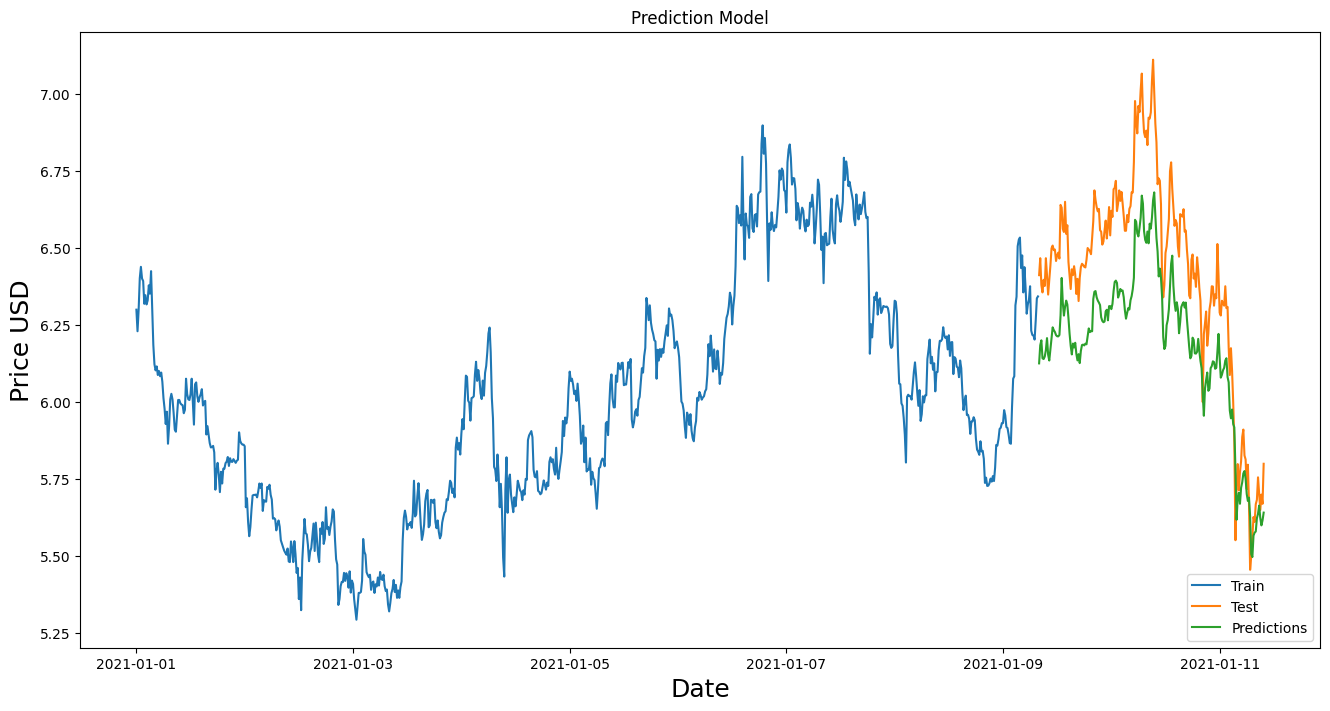

2023-04-08 19:22:30.397642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-08 19:22:30.399599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-08 19:22:30.400920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

InvalidArgumentError: Graph execution error:

Detected at node 'while/MatMul' defined at (most recent call last):
    File "/home/codespace/.python/current/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/codespace/.python/current/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/codespace/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/codespace/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/codespace/.python/current/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/home/codespace/.python/current/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/home/codespace/.python/current/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/codespace/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/home/codespace/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/home/codespace/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/codespace/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/codespace/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/codespace/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_30904/1240544003.py", line 21, in <module>
      pred_price = model.predict(X_test)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/engine/training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/engine/training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/engine/training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/engine/training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in predict_step
      return self(x, training=False)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/layers/rnn/base_rnn.py", line 556, in __call__
      return super().__call__(inputs, **kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/layers/rnn/lstm.py", line 748, in call
      ) = lstm_with_backend_selection(**normal_lstm_kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/layers/rnn/lstm.py", line 1338, in lstm_with_backend_selection
      last_output, outputs, new_h, new_c, runtime = defun_standard_lstm(
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/layers/rnn/lstm.py", line 980, in standard_lstm
      last_output, outputs, new_states = backend.rnn(
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/backend.py", line 5169, in rnn
      final_outputs = tf.compat.v1.while_loop(
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/backend.py", line 5148, in _step
      output, new_states = step_function(
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/layers/rnn/lstm.py", line 966, in step
      z = backend.dot(cell_inputs, kernel)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/backend.py", line 2464, in dot
      out = tf.matmul(x, y)
Node: 'while/MatMul'
Matrix size-incompatible: In[0]: [1,5], In[1]: [1,200]
	 [[{{node while/MatMul}}]]
	 [[sequential_1/lstm_2/PartitionedCall]] [Op:__inference_predict_function_31279]

In [26]:

plt.figure(figsize=(16,8))
plt.title('Prediction Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD', fontsize=18)
plt.plot(train['close'])
plt.plot(test[['close', 'predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# Предсказываем на час вперед
last_60_mins = ohlcv_df[-4:].values
last_60_mins_scaled = norm(last_60_mins)
# last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_mins_scaled)
X_test = np.array(X_test)
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
# pred_price = scaler.inverse_transform(pred_price)
# print(pred_price)
